<a href="https://colab.research.google.com/github/AmanullaChishty/Pytorch/blob/main/PyTorch_paper_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup

In [1]:
import torch


In [2]:
!pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
import torchvision

In [4]:
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] Couldn't find going_modular or helper_functions...")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4177, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 4177 (delta 61), reused 104 (delta 38), pack-reused 4035 (from 1)
Receiving objects: 100% (4177/4177), 651.42 MiB | 23.51 MiB/s, done.
Resolving deltas: 100% (2432/2432), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                          destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [8]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x789154b5f910>,
 ['pizza', 'steak', 'sushi'])

In [10]:
image_batch,label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

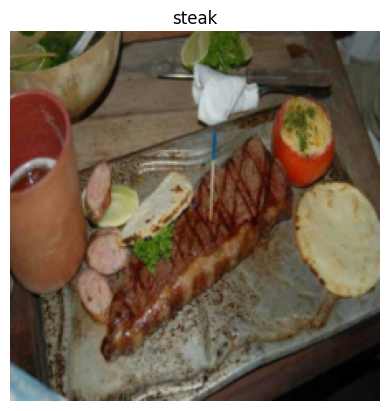

In [11]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

## 3. Replicating the ViT paper

In [12]:
## Calculating patch embedding input and output shapes by hand
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196.0


In [13]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)
print(f"Embedding layer input shape: {embedding_layer_input_shape}")
print(f"Embedding layer output shape: {embedding_layer_output_shape}")

Embedding layer input shape: (224, 224, 3)
Embedding layer output shape: (196.0, 768)


(-0.5, 223.5, 223.5, -0.5)

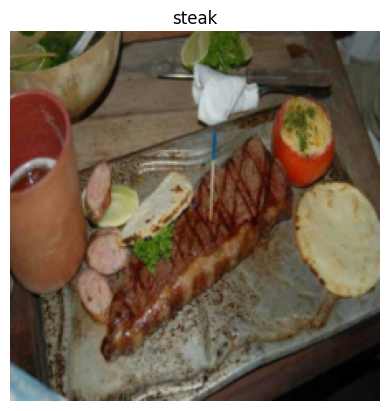

In [14]:
## Turning a single image into patches
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

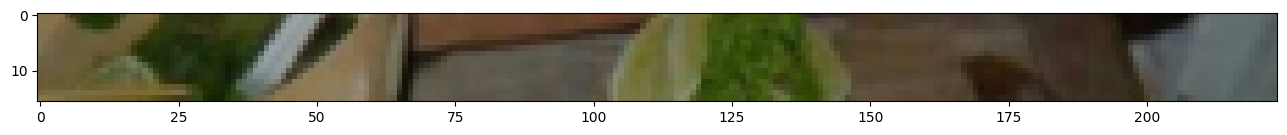

In [15]:
image_permuted = image.permute(1,2,0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


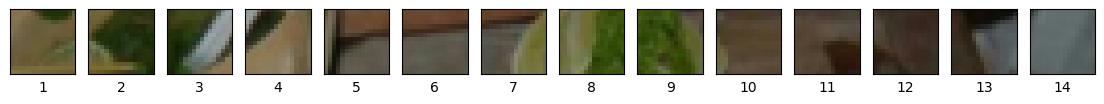

In [16]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size// patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


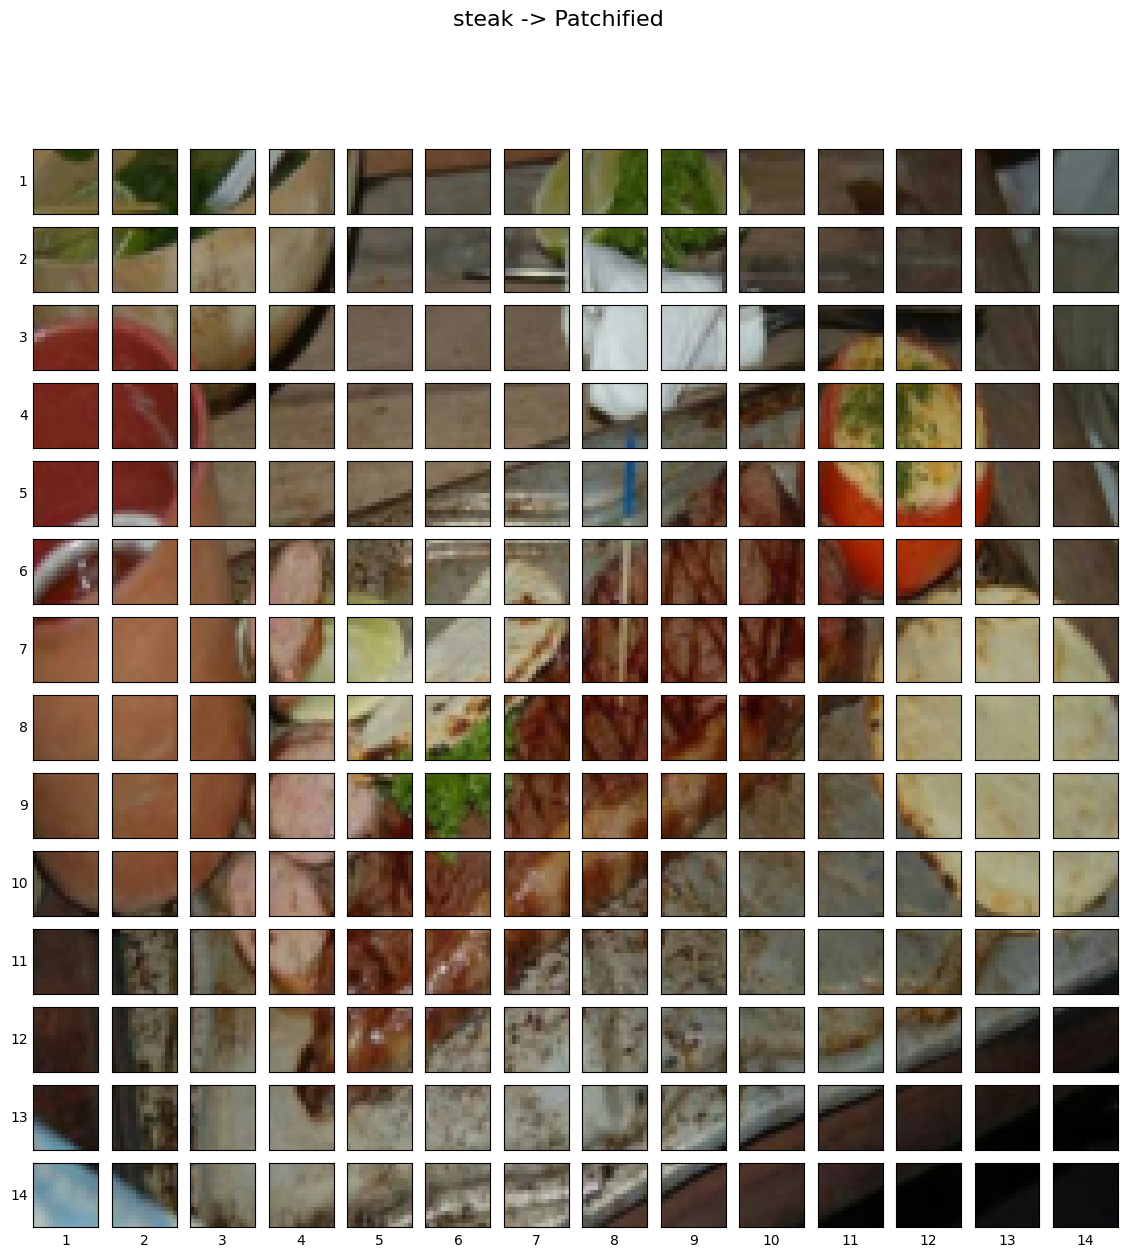

In [17]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size// patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0,img_size,patch_size)):
  for j, patch_width in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 16)
plt.show()


## 4. Image pataches with Conv2d

In [18]:


patch_size = 16
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size = patch_size,
                   stride = patch_size,
                   padding = 0)

(-0.5, 223.5, 223.5, -0.5)

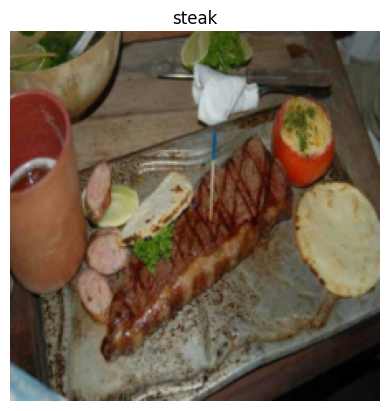

In [19]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape, '-> [batch_size, embedding_dim, feature_map_height, feature_map_width]')

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Showing random convolutional feature maps from indexes: [23, 420, 20, 386, 607]


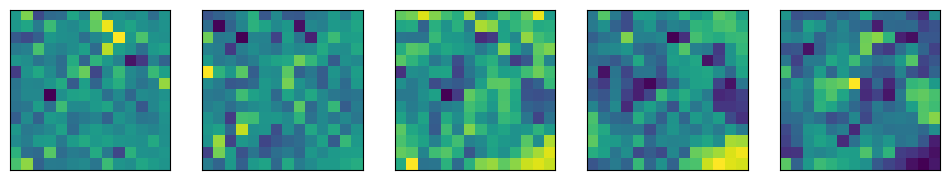

In [21]:
import random
random_indexes = random.sample(range(0,758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize =(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])

In [22]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[0.2584, 0.1515, 0.1803, 0.2967, 0.2552, 0.1956, 0.1572, 0.1747,
           0.1451, 0.2110, 0.2276, 0.1789, 0.1430, 0.2034],
          [0.1737, 0.1009, 0.3280, 0.2716, 0.1746, 0.1969, 0.2039, 0.1672,
           0.1084, 0.1807, 0.1596, 0.1453, 0.1660, 0.1554],
          [0.2794, 0.3029, 0.2792, 0.1648, 0.2541, 0.2520, 0.2383, 0.4417,
           0.3999, 0.2195, 0.0533, 0.0894, 0.1492, 0.1593],
          [0.3024, 0.2795, 0.1007, 0.2028, 0.2670, 0.3147, 0.2570, 0.4240,
           0.2759, 0.1248, 0.1934, 0.2100, 0.2203, 0.1732],
          [0.3053, 0.3627, 0.3063, 0.2659, 0.2873, 0.2240, 0.3003, 0.2518,
           0.1881, 0.2946, 0.2980, 0.2558, 0.2963, 0.2146],
          [0.2667, 0.2511, 0.2710, 0.2832, 0.2760, 0.3534, 0.2405, 0.2183,
           0.2587, 0.2144, 0.3276, 0.3260, 0.2400, 0.2060],
          [0.3468, 0.3564, 0.3526, 0.3109, 0.3147, 0.3530, 0.3767, 0.2051,
           0.2164, 0.2240, 0.2891, 0.3193, 0.3608, 0.3132],
          [0.3186, 0.3497, 0.2463, 0.2750, 0.3997, 0.25

## 5. Flatteing the patch embedding with torch.nn.Flatten()

In [23]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [24]:
flatten = nn.Flatten(start_dim=2,end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image faure map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


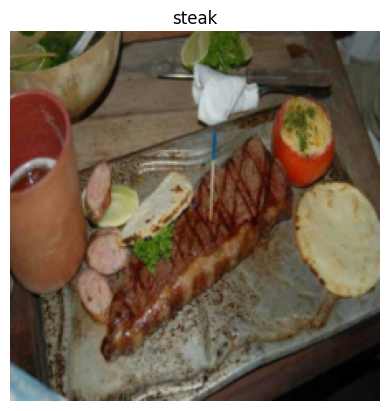

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape: {image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image faure map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

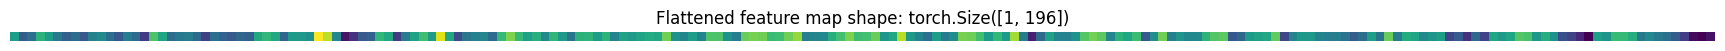

In [27]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [28]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.2584, 0.1515, 0.1803, 0.2967, 0.2552, 0.1956, 0.1572, 0.1747, 0.1451,
          0.2110, 0.2276, 0.1789, 0.1430, 0.2034, 0.1737, 0.1009, 0.3280, 0.2716,
          0.1746, 0.1969, 0.2039, 0.1672, 0.1084, 0.1807, 0.1596, 0.1453, 0.1660,
          0.1554, 0.2794, 0.3029, 0.2792, 0.1648, 0.2541, 0.2520, 0.2383, 0.4417,
          0.3999, 0.2195, 0.0533, 0.0894, 0.1492, 0.1593, 0.3024, 0.2795, 0.1007,
          0.2028, 0.2670, 0.3147, 0.2570, 0.4240, 0.2759, 0.1248, 0.1934, 0.2100,
          0.2203, 0.1732, 0.3053, 0.3627, 0.3063, 0.2659, 0.2873, 0.2240, 0.3003,
          0.2518, 0.1881, 0.2946, 0.2980, 0.2558, 0.2963, 0.2146, 0.2667, 0.2511,
          0.2710, 0.2832, 0.2760, 0.3534, 0.2405, 0.2183, 0.2587, 0.2144, 0.3276,
          0.3260, 0.2400, 0.2060, 0.3468, 0.3564, 0.3526, 0.3109, 0.3147, 0.3530,
          0.3767, 0.2051, 0.2164, 0.2240, 0.2891, 0.3193, 0.3608, 0.3132, 0.3186,
          0.3497, 0.2463, 0.2750, 0.3997, 0.2531, 0.2156, 0.1795, 0.2602, 0.1981,
          0.2307

## 6. Turning the ViT patch to PyTorch Module

In [29]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels=embedding_dim,kernel_size=patch_size,
                             stride = patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,end_dim=3)

  def forward(self,x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size ==0, f"Image resolution ({image_resolution}) must be divisible by the patch size ({patch_size})"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0,2,1)

In [30]:
set_seeds()
patchify = PatchEmbedding(in_channels=3,
                                 patch_size=16,
                                 embedding_dim=768)
print(f"Input image shape : {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape : torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [31]:
random_input_image = (1,3,224,224)
random_input_image_error = (1,3,250,250)

In [32]:
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 7. Creating the class token embedding

In [33]:
print(patch_embedded_image)
print(f"Shape of patch embedded image: {patch_embedded_image.shape} -> [batch_szie, number_of_patches,embedding_dimension]")

tensor([[[-0.3564,  0.0572, -0.0986,  ...,  0.2221, -0.1829,  0.1846],
         [-0.0527, -0.0602, -0.1582,  ...,  0.1216, -0.1307,  0.2102],
         [-0.3631,  0.1705, -0.1030,  ...,  0.2860, -0.2563, -0.1316],
         ...,
         [-0.0145, -0.0356, -0.0289,  ...,  0.0282, -0.0436,  0.0173],
         [-0.0390, -0.0024, -0.0761,  ...,  0.0561, -0.0072,  0.0093],
         [-0.0787,  0.0131, -0.0546,  ...,  0.0475, -0.0151,  0.0245]]],
       grad_fn=<PermuteBackward0>)
Shape of patch embedded image: torch.Size([1, 196, 768]) -> [batch_szie, number_of_patches,embedding_dimension]


In [34]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),requires_grad=True)
print(class_token[:,:,:10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dim]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dim]


In [35]:
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"Shape of patch embedded image with class embedding: {patch_embedded_image_with_class_embedding.shape}")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3564,  0.0572, -0.0986,  ...,  0.2221, -0.1829,  0.1846],
         [-0.0527, -0.0602, -0.1582,  ...,  0.1216, -0.1307,  0.2102],
         ...,
         [-0.0145, -0.0356, -0.0289,  ...,  0.0282, -0.0436,  0.0173],
         [-0.0390, -0.0024, -0.0761,  ...,  0.0561, -0.0072,  0.0093],
         [-0.0787,  0.0131, -0.0546,  ...,  0.0475, -0.0151,  0.0245]]],
       grad_fn=<CatBackward0>)
Shape of patch embedded image with class embedding: torch.Size([1, 197, 768])


## 8. Creating the position embedding

In [36]:
patch_embedded_image_with_class_embedding,patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3564,  0.0572, -0.0986,  ...,  0.2221, -0.1829,  0.1846],
          [-0.0527, -0.0602, -0.1582,  ...,  0.1216, -0.1307,  0.2102],
          ...,
          [-0.0145, -0.0356, -0.0289,  ...,  0.0282, -0.0436,  0.0173],
          [-0.0390, -0.0024, -0.0761,  ...,  0.0561, -0.0072,  0.0093],
          [-0.0787,  0.0131, -0.0546,  ...,  0.0475, -0.0151,  0.0245]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [37]:
number_of_patches = int((height*width)/patch_size**2)

embedding_dim = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dim),requires_grad=True)
print(position_embedding[:,:10,:10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [38]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6436, 1.0572, 0.9014,  ..., 1.2221, 0.8171, 1.1846],
         [0.9473, 0.9398, 0.8418,  ..., 1.1216, 0.8693, 1.2102],
         ...,
         [0.9855, 0.9644, 0.9711,  ..., 1.0282, 0.9564, 1.0173],
         [0.9610, 0.9976, 0.9239,  ..., 1.0561, 0.9928, 1.0093],
         [0.9213, 1.0131, 0.9454,  ..., 1.0475, 0.9849, 1.0245]]],
       grad_fn=<AddBackward0>)
Shape of patch and position embedding: torch.Size([1, 197, 768])


## 9. From Image to Embedding

In [39]:
set_seeds()

patch_szie = 16

print(f"Image tensor shape: {image.shape}")
height,width = image.shape[1],image.shape[2]
print(f"Image height: {height}, image width: {width}")

x= image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Output patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dim),requires_grad=True)
print(f"Class token shape: {class_token.shape}")

patch_embedding_with_class_token = torch.cat((class_token,patch_embedding),dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dim),requires_grad=True)

patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Image height: 224, image width: 224
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 10. Equation 2: Multi-Head Attention (MSA)

In [40]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               attn_dropout: float = 0.0):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                       num_heads=num_heads,
                                                       dropout=attn_dropout,
                                                      batch_first=True)

  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                     key=x,
                                     value=x,
                                    need_weights=False)
    return attn_output

In [41]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                   num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 11. Equation 3: Multilayer Perception (MLP)

In [42]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_dim: int = 3072,
               dropout:float=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,out_features=mlp_dim),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_dim,out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [43]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_dim=3072)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 12. Creating a Transformer Encoder by combining our custom made layers

In [44]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               num_heads: int = 12,
               mlp_dim: int = 3072,
               attn_dropout: float = 0,
               mlp_dropout: float = 0.1):
    super().__init__()

    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                  num_heads=num_heads,
                                                  attn_dropout=attn_dropout)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_dim=mlp_dim,
                              dropout=mlp_dropout)

  def forward(self,x):
    x = x + self.msa_block(x)
    x = x + self.mlp_block(x)
    return x

In [45]:
transformer_encoder_block = TransformerEncoderBlock()

In [46]:
summary(model=transformer_encoder_block,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [47]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [48]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

## 13. Creating a ViT from all the above learnings

In [52]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int =224,
               in_channels: int =3,
               patch_size: int =16,
               num_transformer_layers: int =12,
               embedding_dim:int =768,
               mlp_size:int = 3072,
               num_heads: int =12,
               attn_dropout:float = 0,
               mlp_dropout:float = 0.1,
               embedding_dropout:float = 0.1,
               num_classes: int = 1000):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."


    self.num_patches = (img_size * img_size) // patch_size**2

    self.class_embedding = nn.Parameter(torch.ones(1,1,embedding_dim),requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1,embedding_dim),requires_grad = True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_dim=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Linear(in_features=embedding_dim,out_features=num_classes)

  def forward(self,x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size,-1,-1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token,x),dim=1)
    x = x + self.position_embedding
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = x[:,0]
    x = self.classifier(x)
    return x


In [50]:
batch_size =32
class_token_embedding_single = nn.Parameter(data = torch.randn(1,1,768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

print(f"Class token embedding single: {class_token_embedding_single.shape}")
print(f"Class token embedding expanded: {class_token_embedding_expanded.shape}")

Class token embedding single: torch.Size([1, 1, 768])
Class token embedding expanded: torch.Size([32, 1, 768])


In [53]:
set_seeds()

random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-2.2184,  0.9447,  1.7393]], grad_fn=<AddmmBackward0>)

In [54]:
summary(model=vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 